# General fit  with systematic parameters

(model testing)

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
from scipy.stats import norm
from scipy.stats import f
import matplotlib.pyplot as plt

In [2]:
# Printout settings
np.set_printoptions(precision=3, linewidth=100, suppress=True)

# More advanced: prevent zeros from being stripped from the end of floats:
np.set_printoptions(formatter={'float_kind': '{: 0.3f}'.format})

### (1) Definition of data model

Consider controlled parameter range is [0,1]

In [3]:
# True functional dependece baskground + two signal peaks

def mytrue(x):
    
    bg = 10.0 - 2* x + x*x
    
    sig1 = 20.0 * norm.pdf(x, loc=0.44, scale=0.05)
    
    sig2 = 5.0 * norm.pdf(x, loc=0.55, scale=0.10)

    return bg+sig1+sig2

### (2) Definition of fit model

In [4]:
# Basic function, return function values only
#
#  Parameters: 0 - 2 background
#              3 - 5 first peak
#              6 - 8 second peak
#
def myfun(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    if npar<6 :
        return bg
    
    sig1 = par[3] * norm.pdf(x, loc=par[4], scale=par[5])
    
    if npar<9 :
        return bg + sig1
    
    sig2 = par[6] * norm.pdf(x, loc=par[7], scale=par[8])

    return bg + sig1 + sig2

# Full model: returns values and derivatives

def myfunder(x,par):

    npar = par.size   # should be 6 for sigle peak or 9 for double peak fit

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,npar))

    # Background
    
    bg = par[0] + par[1]*x + par[2]*x*x
    
    der[:,0] = 1
    der[:,1] = x
    der[:,2] = x*x
   
    val += bg
    
    if npar < 6 :
        return val,der
    
    # First signal peak
    
    sig1 = norm.pdf(x, loc=par[4], scale=par[5])
    
    der[:,3] = sig1
    sig1 *= par[3]
    der[:,4] = (x-par[4])/par[5]/par[5]*sig1
    der[:,5] = (x-par[4])*(x-par[4])/par[5]/par[5]/par[5]*sig1
    
    val += sig1
    
    if npar < 9 :
        return val,der
    
    # Second signal peak
    
    sig2 = norm.pdf(x, loc=par[7], scale=par[8])
    
    der[:,6] = sig2
    sig2 *= par[6]
    der[:,7] = (x-par[7])/par[8]/par[8]*sig2
    der[:,8] = (x-par[7])*(x-par[7])/par[8]/par[8]/par[8]*sig2
    
    val += sig2
       
    return val,der


### (3) Generate pseudo data to fit and read background fit results

In [5]:
# Considered values of x

xvec = np.linspace(0.025,0.975,20)

# Measurement precision

svec = np.linspace(2.,4.,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)

In [6]:
# Read background fit output

Nbg = 3

# Reading from file does not work in Confluence...
#
# parfile = "10_bg_fit_par_3.dat"
# covfile = "10_bg_fit_cov_3.dat"

# Fitted parameters

# bgpar = np.fromfile(parfile,sep=' ')    
bgpar = np.array([ 9.921, -1.816,  0.848])

# Covariance matrix

# bgcinput = np.fromfile(covfile,sep=' ')
bgcinput = np.array([ 0.023, -0.104,  0.094, -0.104,  0.681, -0.696,  0.094, -0.696,  0.770])

bgcov = bgcinput.reshape(Nbg,Nbg)

# Inverse of bg covariance matrix

bgcinv = np.linalg.inv(bgcov)


### (4) Iterative fit settings

In [7]:
# Helper function for chi2 calculation
# Uses global data vectors: xvec,yvec,s2vec

def mychi2(parvec):
    fvec = myfun(xvec,parvec) 
    chi2 = np.sum((yvec-fvec)**2/s2vec)

    if UseBG:
        dbgpar = parvec[:Nbg] - bgpar
        chi2 += dbgpar @ bgcinv @ dbgpar

    return chi2

In [8]:
# Number of function parameters to consider  (3, 6 or 9)

Nfun1 = 9

Nfun2 = 6

# Flag to include background constraints (1 or 0)

UseBG = 1

# Initial guess for parameters (max size)

parini = np.zeros(9)

# Background guess or input

parini[0] = 10.
parini[1] = -1.
parini[2] = +1.

# First peak guess

parini[3] = 20.
parini[4] = 0.4
parini[5] = 0.1

# Second peak guess

parini[6] = 5.
parini[7] = 0.5
parini[8] = 0.1


# Initial printout

chi2ini = mychi2(parini) 

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [ 10.000 -1.000  1.000  20.000  0.400  0.100  5.000  0.500  0.100]
  chi^2 =  1638.124   chi^2/N = 81.90622 


In [9]:
# Main fit procedure
# Uses global data vectors: xvec,yvec,s2vec

def myiterfit(parini):
    
    # Main loop

    lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

    dcut = 0.0001   # Required precision (distance from minimum)

    chi2min = mychi2(parini)
    parmin = parini

    par = parini

    Nit = 0
    Nimp = 0

    Nfun = parini.size
    
    Cov = np.zeros((Nfun,Nfun))

    dist = dcut+1

    while dist > dcut :

        # work space

        A = np.zeros((Nfun,Nfun))
        B = np.zeros(Nfun)

        # Values and derivatives at the current point

        fval,fder = myfunder(xvec,par)

        dyvec = yvec-fval

        for l in range(Nfun):
            B[l] = np.sum(fder[:,l]*dyvec/s2vec)
            for k in range(Nfun):
                A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

        # Background uncertainties

        if UseBG:
            dbgpar = par[:Nbg] - bgpar
            for l in range(Nbg):
                B[l] -= np.sum(dbgpar*bgcinv[l,:])
                for k in range(Nbg):
                    A[l,k] += bgcinv[l,k]

        # Do not try to jump directly to the maximum (lam = 0)

        C = np.array(A)
        for l in range(Nfun):
            C[l,l] += lam

        # Inverse of matrix

        Cinv = np.linalg.inv(C)

        # Solution to the problem - required parameter change

        dpar = Cinv @ B

        # Check new parameter values

        parnew = par+dpar

        fnew = myfun(xvec,parnew) 

        chi2new = np.sum((yvec-fnew)**2/s2vec)

        if UseBG:
            dbgpar = parnew[:Nbg] - bgpar
            chi2new += dbgpar @ bgcinv @ dbgpar

        # Distance to minimum (assuming current errors)

        Cov = np.linalg.inv(A)
        e2par = np.diagonal(Cov)
        dist = np.sum(dpar*dpar/e2par)

        Nit+=1

        if chi2new < chi2min :
            Nimp += 1
            lam /= 10
            chi2min = chi2new
            par = parnew
        else:
            lam *= 10


    # Parameter uncertainties 
    # (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

    epar = np.sqrt(np.diagonal(Cov))

    print("\n Fit results:\n\n     par         sigma_p\n")

    for ip in range(par.size):
        print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

    # Calculate correlation matrix, including rounding

    Corr = np.array(Cov)

    print("\n Correlation matrix\n")
    for ip in range(par.size):
        for jp in range(par.size):
            Corr[ip,jp]=Corr[ip,jp]/epar[ip]/epar[jp]

        print(Corr[ip,:])

    chi2 = mychi2(par)

    print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))

    return chi2,par,epar

### (5) Actual fit of two hypothesis

In [10]:
# For first hypothesis

chi2_1,par_1,epar_1 = myiterfit(parini[:Nfun1])

# For function plotting

x_fun = np.linspace(0.,1.,101)
fun_1 = myfun(x_fun,par_1) 

bg_1 = myfun(x_fun,par_1[:3])
f1_1 = myfun(x_fun,par_1[:6])


 Fit results:

     par         sigma_p

     9.922  +/-  0.151 
    -1.770  +/-  0.823 
     0.773  +/-  0.875 
    22.012  +/-  0.741 
     0.442  +/-  0.003 
     0.054  +/-  0.002 
     2.728  +/-  0.562 
     0.583  +/-  0.037 
     0.063  +/-  0.028 

 Correlation matrix

[ 1.000 -0.831  0.706  0.002 -0.002 -0.001  0.011 -0.001  0.004]
[-0.831  1.000 -0.961 -0.012 -0.001 -0.012 -0.012 -0.005 -0.001]
[ 0.706 -0.961  1.000  0.016  0.004  0.015  0.008  0.008 -0.005]
[ 0.002 -0.012  0.016  1.000  0.809  0.566 -0.333  0.822 -0.871]
[-0.002 -0.001  0.004  0.809  1.000  0.836 -0.586  0.929 -0.863]
[-0.001 -0.012  0.015  0.566  0.836  1.000 -0.662  0.844 -0.717]
[ 0.011 -0.012  0.008 -0.333 -0.586 -0.662  1.000 -0.559  0.292]
[-0.001 -0.005  0.008  0.822  0.929  0.844 -0.559  1.000 -0.844]
[ 0.004 -0.001 -0.005 -0.871 -0.863 -0.717  0.292 -0.844  1.000]

 chi^2 =    14.963   chi^2/Ndf =  1.36024 


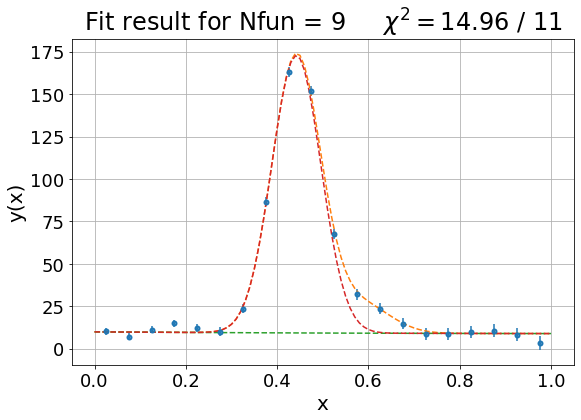

In [11]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(x_fun,fun_1,'--')
plt.plot(x_fun,bg_1,'--')
plt.plot(x_fun,f1_1,'--')

plt.title('Fit result for Nfun = '+str(Nfun1) +'     $\chi^{2} = $'+str(int(100*chi2_1+0.5)/100.)+' / '+str(xvec.size-Nfun1),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '10_comb_fit_'+str(Nfun1)+'.png'
plt.savefig(fname)

In [12]:
# For second hypothesis

chi2_2,par_2,epar_2 = myiterfit(parini[:Nfun2])

# For function plotting

fun_2 = myfun(x_fun,par_2) 

bg_2 = myfun(x_fun,par_2[:3])


 Fit results:

     par         sigma_p

     9.951  +/-  0.151 
    -1.808  +/-  0.823 
     0.861  +/-  0.875 
    26.565  +/-  0.367 
     0.448  +/-  0.001 
     0.061  +/-  0.001 

 Correlation matrix

[ 1.000 -0.831  0.706  0.012  0.008  0.009]
[-0.831  1.000 -0.961 -0.025 -0.004 -0.030]
[ 0.706 -0.961  1.000  0.024  0.000  0.029]
[ 0.012 -0.025  0.024  1.000  0.000 -0.573]
[ 0.008 -0.004  0.000  0.000  1.000  0.088]
[ 0.009 -0.030  0.029 -0.573  0.088  1.000]

 chi^2 =   122.513   chi^2/Ndf =  8.75089 


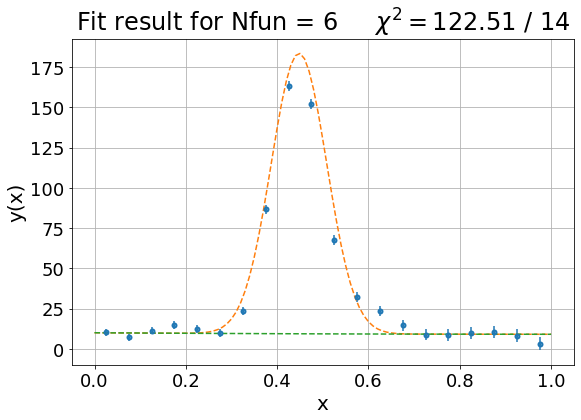

In [13]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(x_fun,fun_2,'--')
plt.plot(x_fun,bg_2,'--')

plt.title('Fit result for Nfun = '+str(Nfun2) +'     $\chi^{2} = $'+str(int(100*chi2_2+0.5)/100.)+' / '+str(xvec.size-Nfun2),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '10_comb_fit_'+str(Nfun2)+'.png'
plt.savefig(fname)

### (6) Test the two hypotheiss

In [14]:
# Fit with all parameters

Nchi_1 = xvec.size-Nfun1 
chi2ndf_1 = chi2_1/Nchi_1

# Change when removing parameters

Nchi_2 = Nfun1-Nfun2
chi2ndf_2 = (chi2_2-chi2_1)/Nchi_2

# Test value

Ftest = chi2ndf_2/chi2ndf_1

ptest =  f.sf(Ftest,Nchi_2,Nchi_1)

In [15]:
print("F-test result  p = %.4g " % (ptest))
print("probability of Chi2 increase by %6.3f when removing %d needless parameters" % (chi2_2-chi2_1,Nchi_2))

F-test result  p = 2.538e-05 
probability of Chi2 increase by 107.550 when removing 3 needless parameters
